### CS182 project - Deliver ideas of CGCNN

### General Explanation

The key idea of CGCNN is to represent crystal structure by a crystal graph, which encodes not only
the atomic information but also bonding information between atoms based on the distance. Here we
will let each atomic feature vector as vi, which encodes the property of the atom corresponding to
node i. The edge feature vector is represented as u(i,j)k, which encodes k-th bond connecting atom
i, j. Note that there can be several bonds between atoms, which originate from the periodic nature of
crystals. <br />
Obviously, there are many ways to encode atomic and bond data. For the sake of simplicity, we will
follow the methods used in the CGCNN paper, which used a pre-defined encoding vector to change
atoms into vectors. These vectors have 92 dimensions, and for 100 atoms in the periodic table, they
have different encodings which consist of 0 and 1. For the edge feature vectors, there also can be
many ways to encode bond information; bond length, angle, and covalency. However, we will only
use bond-length information between nearest neighbors, by applying a Gaussian kernel to change
it to encoding vectors. One can follow the homework notebook on how this embedding is done to
NaCl(salt) Crystal.

### Encoding Crystal into Crystal Graph

In [3]:
# Note: Need pymatgen

In [2]:
# Uncommnet this to install pymatgen
#!pip install pymatgen

In [ ]:
import os
import sys
import csv
import json
import torch
import torch.nn as nn
import random
import warnings
warnings.filterwarnings('ignore')
import functools
import sklearn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba_array

from pymatgen.core.structure import Structure
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import CrystalNN
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

from data_utils import CIFData
from data_utils import AtomCustomJSONInitializer
from data_utils import AtomInitializer
from data_utils import GaussianDistance

In [4]:
# Uncomment this to extract data
# !unzip cgcnn_data.zip
# !unzip hw_data.zip

Let's convert salt (NaCl) to crystadddl graph. <br />
You can use print method to see the lattice and position of Na, Cl atoms in the cell. <br />
We will also visualize it to a graph. Each node of graph is atom in the crystal, and edge is bonds that have distance as information. <br /> <br />
Note that we will use pymatgen package (Python Materials Genomics) which is an open source Python library for materials analysis. But you don't need to worry about that too much. Only important class is 'Structure' class, which can load structure data of materials by Structure.from_file method. After you load it, you can get the site information using Structure_object[index_want_to_check], and this Site object has some useful attributes, such as specie. You can check what specie is in the site by using Structure_object[index].specie

In [5]:
# Load structure from CIF file 
nacl = Structure.from_file('hw_data/sample_regression/1000041.cif')
print(nacl)

Full Formula (Na4 Cl4)
Reduced Formula: NaCl
abc   :   5.620000   5.620000   5.620000
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Na+   0    0    0
  1  Na+   0    0.5  0.5
  2  Na+   0.5  0    0.5
  3  Na+   0.5  0.5  0
  4  Cl-   0.5  0.5  0.5
  5  Cl-   0.5  0    0
  6  Cl-   0    0.5  0
  7  Cl-   0    0    0.5


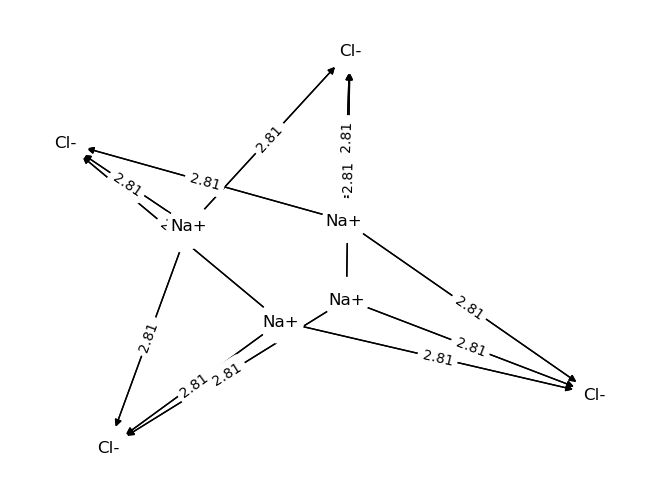

In [6]:
# Visualization of the structure using the CIF file 
crystal = CrystalNN()

sg = StructureGraph.with_local_env_strategy(nacl, crystal)

node_labels = {}
for i, site in enumerate(nacl):
    label = "{}".format(site.specie)
    node_labels[i] = label

edge_weights = {}
for edge in sg.graph.edges():
    dist = nacl.get_distance(edge[0], edge[1])
    edge_weights[edge] = dist

pos = nx.spring_layout(sg.graph)
nx.draw(sg.graph, pos, with_labels=True, labels=node_labels, font_size=12, node_size=1000, node_color="w")
nx.draw_networkx_edge_labels(sg.graph, pos, edge_labels=edge_weights, font_size=10)
plt.axis("off")
plt.show()

Next we will encode atoms in the node to atomistic feature vectors using pre-difined atom embedding. <br />
atom_init.json is containing vector embedding of atoms, where key (1, 2, 3, ..., 100) represent atomic number
and values are encoding vectors. <br />
You can try different atom embedding too if you want.

In [ ]:
# Load embedding file.
element_embedding_file = 'hw_data/sample_regression/atom_init.json'
with open(element_embedding_file) as f:
    elem_embedding = json.load(f)
elem_embedding = {int(key): value for key, value
                  in elem_embedding.items()}

atom_fea = None
############################################################################
# TODO: Encode crsytal data to atomistic features. 
# (Hint: Use np.vstack and elem_embedding to join all embedded specie numbers of NaCl. 
# Also, check out pymatgen.core.structure.specie.number attribute.
# nacl[i].specie will give you what kind of specie it is,
# And number attribute will give atomic number of that specie.)
# Atom_feature shd have shape of (# of atoms, len(embedding vector))

# YOUR CODE HERE

# Solution
atom_fea = np.vstack([elem_embedding[nacl[i].specie.number]
                      for i in range(len(nacl))])
############################################################################
assert atom_fea is not None
atom_fea = torch.Tensor(atom_fea)


assert atom_fea.shape == (8,92)

Next, we will get neighbor information from each atoms in the cell.
We will get help from pymatgen package.
get_all_neighbor function of structure object returns atoms within
the input radius. Note that here len(all_nbrs) is 8 since there are
8 atoms (4 Na+, 4 Cl-) in the cell. Each list contain the neighbor
atom information considering periodicity.
We will use 12 nearest neighbors after sorting with distance.

In [8]:
all_nbrs = nacl.get_all_neighbors(r = 8, include_index=True)
all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]

assert len(all_nbrs) == 8

nbr_fea_idx, nbr_fea = [], []
for nbr in all_nbrs:
    # Note: x[1] returns distance to neighbors.
    # Note: x[2] returns index of original structure object
    nbr_fea_idx.append(list(map(lambda x: x[2],
                                nbr[:12])))
    nbr_fea.append(list(map(lambda x: x[1],
                            nbr[:12])))

# nbr_fea_idx contain information of nearest neighbor atoms 
# from ith row (ith atom in the cell)
# For example, 0th atom (Na+ (0.0000, 0.0000, 0.0000)) is neighbored
# with 5th, 6th, 7th, etc...
# nbr_fea contain information of nearest neighbot distance. 
nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
nbr_fea_idx = torch.LongTensor(nbr_fea_idx)

nbr_fea_idx_standard = torch.LongTensor([[5, 6, 7, 7, 6, 5, 2, 1, 2, 1, 3, 3],
                                         [4, 7, 6, 7, 6, 4, 2, 0, 3, 2, 3, 3],
                                         [4, 7, 5, 7, 5, 4, 0, 3, 1, 3, 3, 1],
                                         [4, 6, 5, 6, 5, 4, 2, 1, 1, 2, 0, 0],
                                         [3, 1, 2, 3, 2, 1, 6, 5, 6, 5, 7, 7],
                                         [2, 3, 0, 3, 0, 2, 4, 4, 6, 6, 4, 7],
                                         [1, 3, 0, 3, 0, 1, 4, 4, 5, 5, 5, 4],
                                         [2, 1, 0, 2, 1, 0, 4, 5, 5, 4, 6, 6]])

assert torch.equal(nbr_fea_idx, nbr_fea_idx_standard)

Now we have two features, atomic feature and neighbor feature.
Note that neighbor feature is discontionous information with respect to the distance.
Therefore we will expand (which means we will stack data based on the current discontinous distance value) neighbor feature using Gaussian Kernel (or Gaussian filter)
https://en.wikipedia.org/wiki/Gaussian_filter <br />
While expanding the neighbor feature, one can set the distance range and step. Here we will use minimum distance 0, maximum distance 12, and step size of 0.2, which will expanded to dimension size of 61.

In [9]:
dmin = 0
dmax = 12
step = 0.2
var = step
filter_step = np.arange(dmin, dmax+step, step)

def expand(distances):
    ############################################################################
    # TODO: Implement the expand function using a Gaussian kernel.
    # raise NotImplementedError()
    
    # Solution
    return np.exp(-(distances[..., np.newaxis] - filter_step)**2 / var**2)
    ############################################################################

    
nbr_fea_gaussian = expand(nbr_fea)

In [10]:
gdf = GaussianDistance(dmin=0, dmax=12, step=0.2)
nbr_fea = gdf.expand(nbr_fea)

In [11]:
assert np.array_equal(nbr_fea_gaussian, nbr_fea)

### Build a Model

After building the crystal graph, the convolutional neural network act on top of the graph, and
consecutive fully connected networks and pooling layer are used to predict the property of crystals.
The convolution layer iteratively updates the atom feature vector $v_{i}$ by message passing with
surrounding atoms and bonds with a non-linear graph convolution function:

$ v_{i}^{(t+1)} = Conv(v_{i}^{(t)}, v_{j}^{(t)}, u_{(i,j)_{k}}), (i,j)_{k} \in G $

And then consequetive pooling layer and hidden fully connected layer will generate output of model:

$ v_{c} = Pool(v_{0}^{(0)}, v_{1}^{(0)}, ..., v_{N}^{(0)}, ..., v_{N}^{(R)}) $

Note that we can use any Convolution and Pooling layer if we maintain the permutation invariance. Here we will try two different convolution layer. Try to implement WeightShareConvLayer in the TODO section of model_hw.py. We will offer solution for the ConvLayer. Note that we will do not change pooling layer, and you can use any activation function you use. But try to use sigmoid function here. After you implement WeightShareConvLayer, try to implement CrystalGraphConvNet by filling in the TODO section of model_hw.py. You can find a detailed explanation there. 

1. WeightShareConvLayer; This is a Convolution weight matrix is shared by all neighbors. <br />
$ v_{i}^{(t+1)} = g[(\sum_{j,k}v_{j}^{(t)} \oplus u_{(i,j)_{k}})W_{c}^{(t)}+v_{i}^{(t)}W_{s}^{(t)}+b^{(t)}] $ <br />
Here $W_{c}, W_{s},$ and $b$ are the convolution weight matrix, self-weight matrix, and bias. <br />


2. ConvLayer; This is a Convolution weight matrix is differentiated at all neighbor pairs. <br />
$ v_{i}^{(t+1)} = v_{i}^{(t+1)} + \sum_{j,k}\sigma(z_{(i,j)_{k}}^{(t)}W_{f}^{(t)}+b_{f}^{(t)}) \odot g(z_{(i,j)_{k}}^{(t)}W_{s}^{(t)}+b_{s}^{(t)}) $ <br />
Here $z_{(i,j)_{k}} = v_{i} \oplus v_{j} \oplus u_{(i,j)_{k}}$, $\odot$ denotes element-wise multiplication and $\sigma$ denotes a sigmoid function.

In [12]:
from model_hw import CrystalGraphConvNet
from model_hw import ConvLayer
from model_hw import WeightShareConvLayer

In [13]:
# For testing purpose
data_dir = './cgcnn_data/sample-regression'
test = CIFData(data_dir)
(atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = test[-1]
structures, _, _ = test[-1]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

In [14]:
torch.manual_seed(123)

convlayer_test = ConvLayer(92, 41)
convlayer_test_result = convlayer_test.forward(atom_fea, nbr_fea, nbr_fea_idx)

############################################################################
# TODO: Implement the WeightShareConvLayer model in model_hw.py
############################################################################

weightshare_test = WeightShareConvLayer(92, 41)
weightshare_test_result = weightshare_test.forward(atom_fea, nbr_fea, nbr_fea_idx)

assert convlayer_test_result.shape == (8, 92)
assert weightshare_test_result.shape == (8, 92)

In [15]:
# Simple test
# Set seed using manual_seed
# TODO explanation about crystal_atom_idx
torch.manual_seed(123)
crystal_atom_idx = [torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7]).long()]
############################################################################
# TODO: Implement the CrystalGraphConvNet model in model_hw.py
############################################################################

model1 = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len, option='C')
out = model1.forward(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
assert (out.item() - 0.6627038) < 1e-6

model2 = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len, option='WC')
out = model2.forward(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
assert (out.item() - -0.5442343) < 1e-6

### Training

Now we are all set to test our model. We will train our model to simplified dataset, which consists of ~700 Perovskite materials. We will predict the energy (which is calculated already with DFT, unit is eV) of Perovskites, and see how the model performs. After run the following section, try to anser the question. Note that you can find your prediction and corresponding structures in test_result.csv file.

Q. If you built a model, let's train and visualize it. What is the difference between two models? Which one performs better and why do you think so? <br />
Based on what you observed, can you make a convolution layer that performs better?

Hint: Among two convolution layers, ConvLayer performs better in general. This is because the local environments can always change, so maintaining same weights to all local environments makes prediction worse. However, you can see that in Perovskite dataset, WeightShareConvLayer performs better because Perovskite all have similar symmetry, and local environments of them are not much different

In [16]:
from data_utils import collate_pool, get_train_val_test_loader
from train_utils import Normalizer, train, validate, save_checkpoint
from model_hw import CrystalGraphConvNet
from random import sample

In [17]:
torch.manual_seed(123)

# set parameters
data_dir = './hw_data/perovskite_energy'
batch_size = 8
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

# get dataset

dataset = CIFData(data_dir)
collate_fn = collate_pool
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_fn,
    batch_size=batch_size,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    return_test=True)

In [18]:
# normalize target

if len(dataset) < 500:
    warnings.warn('Dataset has less than 500 data points. '
                    'Lower accuracy is expected. ')
    sample_data_list = [dataset[i] for i in range(len(dataset))]
else:
    sample_data_list = [dataset[i] for i in
                        sample(range(len(dataset)), 500)]
_, sample_target, _ = collate_pool(sample_data_list)
normalizer = Normalizer(sample_target)

In [19]:
# build model
structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]
############################################################################
# TODO: Tune the following parameters and model to optimize performance.
# Note: You can change your convolution layer with option argument in 
# CrystalGraphConvNet. C is ConvLayer, WC is WeightShareConvLayer.
############################################################################
# number of hidden atom features in conv layers
atom_fea_len = 64
# number of hidden features after pooling
h_fea_len = 128
# number of conv layers
n_conv = 3
# number of hidden layers after pooling
n_h = 1

model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=atom_fea_len,
                            n_conv=n_conv,
                            h_fea_len=h_fea_len,
                            n_h=n_h, option='C')

In [20]:
# set hyperparameters, change the parameters to get better results
epochs = 15
criterion = nn.MSELoss()
lr = 0.01
momentum = 0.9
weight_decay = 0

optimizer = optim.SGD(model.parameters(), lr,
                              momentum=momentum,
                              weight_decay=weight_decay)

# optimizer = optim.Adam(model.parameters(), lr,
#                         weight_decay=weight_decay)
lr_milestones = [100]
scheduler = MultiStepLR(optimizer, milestones=lr_milestones,
                            gamma=0.1)

In [21]:
running_record = {'train_loss': [], 'train_mae': [],
                    'val_loss': [], 'val_mae': []}

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)
    
    best_mae_error = 1e10
    # train for one epoch
    train_loss, train_mae = train(train_loader, model, criterion, optimizer, epoch, normalizer)

    # evaluate on validation set
    val_loss, val_mae = validate(val_loader, model, criterion, normalizer)

    # append loss and mae to running record. Convert tensor to float if necessary
    running_record['train_loss'].append(train_loss)
    running_record['train_mae'].append(train_mae)
    running_record['val_loss'].append(val_loss)
    running_record['val_mae'].append(val_mae)


    if val_mae != val_mae:
        print('Exit due to NaN')
        sys.exit(1)

    scheduler.step()

    # remember the best mae_eror and save checkpoint
    is_best = val_mae < best_mae_error
    best_mae_error = min(val_mae, best_mae_error)

    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_mae_error': best_mae_error,
        'optimizer': optimizer.state_dict(),
        'normalizer': normalizer.state_dict(),
    }, is_best)


Epoch 0/14
----------


100%|███████████████████████████████████████████| 67/67 [00:21<00:00,  3.12it/s]


Train: 	Time 0.246	Data 0.168	Loss 1.0064	MAE 54.459


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03it/s]


Test: 	Time 0.412	Loss 0.4892	MAE 40.253
Epoch 1/14
----------


100%|███████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Train: 	Time 0.220	Data 0.152	Loss 0.6307	MAE 39.189


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]


Test: 	Time 0.405	Loss 0.8308	MAE 51.584
Epoch 2/14
----------


100%|███████████████████████████████████████████| 67/67 [00:18<00:00,  3.54it/s]


Train: 	Time 0.208	Data 0.150	Loss 0.6201	MAE 38.471


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.04it/s]


Test: 	Time 0.406	Loss 0.4942	MAE 35.135
Epoch 3/14
----------


100%|███████████████████████████████████████████| 67/67 [00:19<00:00,  3.49it/s]


Train: 	Time 0.212	Data 0.149	Loss 0.5625	MAE 36.203


100%|█████████████████████████████████████████████| 9/9 [00:13<00:00,  1.46s/it]


Test: 	Time 0.904	Loss 0.5425	MAE 40.618
Epoch 4/14
----------


100%|███████████████████████████████████████████| 67/67 [00:19<00:00,  3.50it/s]


Train: 	Time 0.211	Data 0.150	Loss 0.6808	MAE 43.837


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.06it/s]


Test: 	Time 0.389	Loss 0.4754	MAE 41.545
Epoch 5/14
----------


100%|███████████████████████████████████████████| 67/67 [00:19<00:00,  3.36it/s]


Train: 	Time 0.223	Data 0.156	Loss 0.5892	MAE 37.267


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]


Test: 	Time 0.395	Loss 0.4730	MAE 44.930
Epoch 6/14
----------


100%|███████████████████████████████████████████| 67/67 [00:19<00:00,  3.46it/s]


Train: 	Time 0.214	Data 0.153	Loss 0.4989	MAE 34.168


100%|█████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]


Test: 	Time 0.458	Loss 0.6255	MAE 43.454
Epoch 7/14
----------


100%|███████████████████████████████████████████| 67/67 [00:19<00:00,  3.51it/s]


Train: 	Time 0.210	Data 0.151	Loss 0.5025	MAE 33.486


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]


Test: 	Time 0.405	Loss 0.4627	MAE 42.372
Epoch 8/14
----------


100%|███████████████████████████████████████████| 67/67 [00:18<00:00,  3.56it/s]


Train: 	Time 0.206	Data 0.149	Loss 0.5437	MAE 37.471


100%|█████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]


Test: 	Time 0.484	Loss 0.3625	MAE 34.471
Epoch 9/14
----------


100%|███████████████████████████████████████████| 67/67 [00:18<00:00,  3.55it/s]


Train: 	Time 0.207	Data 0.149	Loss 0.4624	MAE 34.295


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.06it/s]


Test: 	Time 0.393	Loss 0.5161	MAE 44.592
Epoch 10/14
----------


100%|███████████████████████████████████████████| 67/67 [00:18<00:00,  3.62it/s]


Train: 	Time 0.202	Data 0.142	Loss 0.4524	MAE 34.097


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]


Test: 	Time 0.401	Loss 0.4711	MAE 38.106
Epoch 11/14
----------


100%|███████████████████████████████████████████| 67/67 [00:20<00:00,  3.35it/s]


Train: 	Time 0.224	Data 0.159	Loss 0.4972	MAE 34.538


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]


Test: 	Time 0.401	Loss 0.4282	MAE 41.408
Epoch 12/14
----------


100%|███████████████████████████████████████████| 67/67 [00:18<00:00,  3.59it/s]


Train: 	Time 0.204	Data 0.147	Loss 0.4259	MAE 33.707


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.06it/s]


Test: 	Time 0.392	Loss 0.4729	MAE 39.691
Epoch 13/14
----------


100%|███████████████████████████████████████████| 67/67 [00:19<00:00,  3.52it/s]


Train: 	Time 0.209	Data 0.149	Loss 0.4054	MAE 32.458


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]


Test: 	Time 0.399	Loss 0.4873	MAE 34.707
Epoch 14/14
----------


100%|███████████████████████████████████████████| 67/67 [00:18<00:00,  3.64it/s]


Train: 	Time 0.200	Data 0.138	Loss 0.4295	MAE 32.980


100%|█████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]

Test: 	Time 0.398	Loss 0.5460	MAE 44.589


In [22]:
# test best model
print('---------Evaluate Model on Test Set---------------')
best_checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])
_, l=validate(test_loader, model, criterion, normalizer, test=True)

---------Evaluate Model on Test Set---------------


100%|█████████████████████████████████████████████| 9/9 [00:09<00:00,  1.01s/it]

Test: 	Time 0.459	Loss 1.2363	MAE 53.165


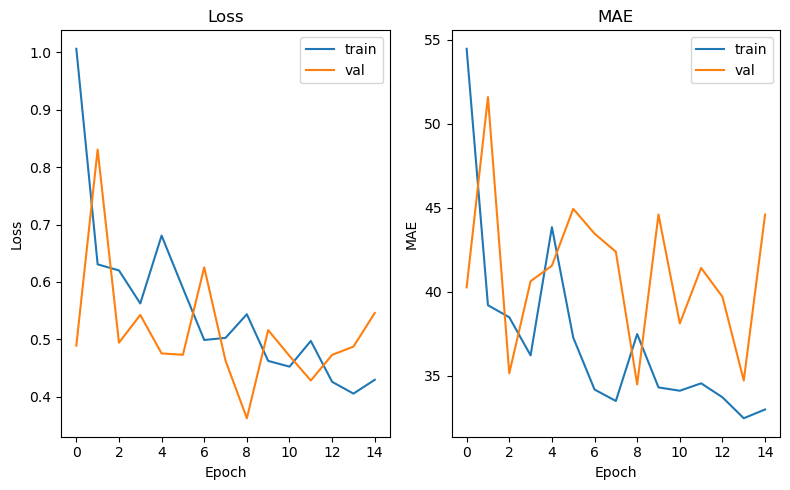

In [23]:
# visualize the training and val loss 
# visualize the training and val mae
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].plot(running_record['train_loss'], label='train')
ax[0].plot(running_record['val_loss'], label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Loss')
# set x axis to be integer
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1].plot(running_record['train_mae'], label='train')
ax[1].plot(running_record['val_mae'], label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
ax[1].set_title('MAE')
# set x axis to be integer
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()